In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from math import sqrt
from pmdarima import auto_arima
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [50]:
df=pd.read_csv(r'C:\projects\goldpredict\notebook\data\gold2024.csv')
df

,date,price
0,2016-01-01,2252.600000
1,2016-01-02,2454.500000
2,2016-01-03,2708.100000
3,2016-01-04,2577.800000
4,2016-01-05,2597.750000
...,...,...
2712,2024-02-23,5498.000000
2713,2024-02-26,5498.000000
2714,2024-02-27,5514.950195
2715,2024-02-28,5514.899902


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2717 non-null   object 
 1   price   2717 non-null   float64
dtypes: float64(1), object(1)
memory usage: 42.6+ KB


In [52]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [53]:
gold=df.copy()

In [54]:
df.set_index('date',drop=True,inplace=True)
df

,price
date,
2016-01-01,2252.600000
2016-01-02,2454.500000
2016-01-03,2708.100000
2016-01-04,2577.800000
2016-01-05,2597.750000
...,...
2024-02-23,5498.000000
2024-02-26,5498.000000
2024-02-27,5514.950195


In [55]:
## Making data stationary
df_diff=df.diff().dropna()
# Perform Augmented Dickey-Fuller test to check if the time series is now stationary
result = adfuller(df_diff['price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -28.38674424688238
p-value: 0.0
Critial Values:
   1%, -3.4327860097199814
Critial Values:
   5%, -2.862616249081039
Critial Values:
   10%, -2.5673429234848517


In [56]:
df_diff

,price
date,
2016-01-02,201.900000
2016-01-03,253.600000
2016-01-04,-130.300000
2016-01-05,19.950000
2016-01-06,19.950000
...,...
2024-02-23,0.000000
2024-02-26,0.000000
2024-02-27,16.950195


In [57]:
gold

,date,price
0,2016-01-01,2252.600000
1,2016-01-02,2454.500000
2,2016-01-03,2708.100000
3,2016-01-04,2577.800000
4,2016-01-05,2597.750000
...,...,...
2712,2024-02-23,5498.000000
2713,2024-02-26,5498.000000
2714,2024-02-27,5514.950195
2715,2024-02-28,5514.899902


In [58]:
# Splitting Train and Test Data
size = int(len(df)*0.8)
train_data =df[:size]
test_data =df[size:]

In [59]:
train_data

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75
...,...
2021-12-08,4181.50
2021-12-09,4219.40
2021-12-10,4264.70


In [60]:
test_data

,price
date,
2021-12-13,4351.400000
2021-12-14,4328.200000
2021-12-15,4348.700000
2021-12-16,4399.800000
2021-12-17,4394.400000
...,...
2024-02-23,5498.000000
2024-02-26,5498.000000
2024-02-27,5514.950195


In [61]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 2016-01-01 00:00:00 2021-12-12 00:00:00 
 Test: 2021-12-13 00:00:00 2024-02-29 00:00:00


# **Evaluation Metric MAPE**

In [62]:
def MAPE(pred,org):
  temp=np.abs((pred-org)/org)*100
  return np.mean(temp)

# **Exponential MEthods**

In [63]:
# Simple Exponential Method
# Using Forecast Attribute
ses_model=SimpleExpSmoothing(train_data['price']).fit(optimized=True)
test_pred_ses=ses_model.forecast(len(test_data))
train_pred_ses=ses_model.fittedvalues
test_rmse_ses=sqrt(mean_squared_error(test_pred_ses,test_data.price))
train_rmse_ses=sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses=MAPE(test_pred_ses,test_data.price)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 8.451404198573755 
 Train Root Mean Squared Error = 114.12078949541744 
 Test Root Mean Squared Error  = 737.4297816411639


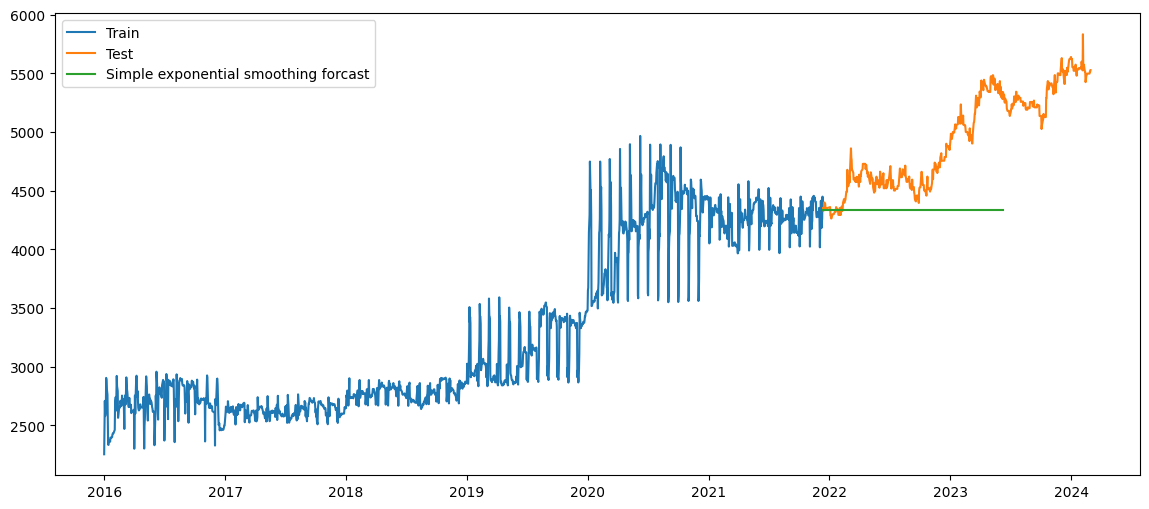

In [64]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

 ### No seasonality captures. Most recent observation gets higher weightages than the older ones for forecasting.

# Holt method (Double Exponential)

In [65]:
dexp_model=Holt(train_data).fit(optimized=True)
test_pred_dexp=dexp_model.forecast(len(test_data))
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.price))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.price)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 3.7597882773510456 
 Train Root Mean Squared Error = 117.01279322925915 
 Test Root Mean Squared Error  = 438.9750781997079


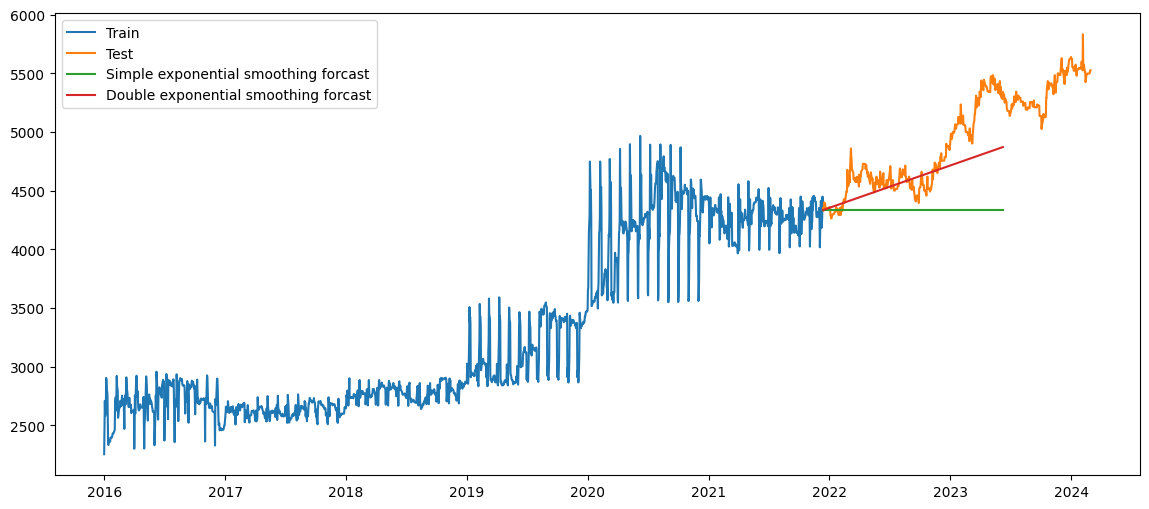

In [66]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### We can see that we are able to capture the trend of the data.We were not able to capture the seasonality.

# Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)


In [67]:
texp_add_model=ExponentialSmoothing(train_data,seasonal='add',trend='add',seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp=texp_add_model.forecast(len(test_data))
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.price))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.price)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 3.2428978647277895 
 Train Root Mean Squared Error = 117.60192331070063 
 Test Root Mean Squared Error  = 382.7033514171363


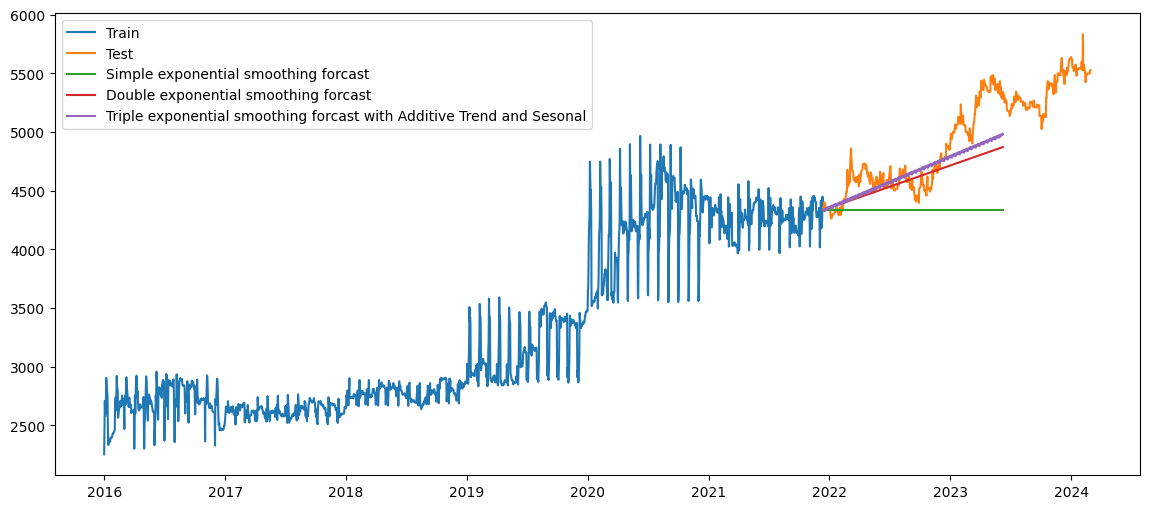

In [68]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

# Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [69]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(len(test_data))
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.price))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.price)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error   = 3.3677753554688503 
 Train Root Mean Squared Error = 117.99118732655256 
 Test Root Mean Squared Error  = 398.1316105537215


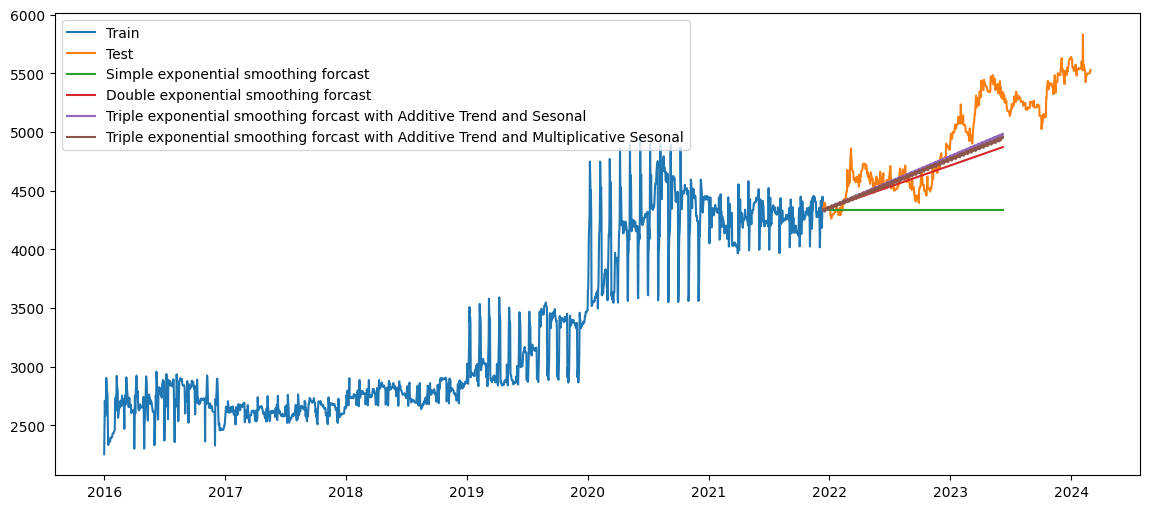

In [70]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

# Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [71]:
texp_ad_mul_model = ExponentialSmoothing(train_data,seasonal="add",trend="mul",
                    seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(len(test_data))
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.price))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.price)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error   = 604.8490922461042 
 Train Root Mean Squared Error = 240.29050499540455 
 Test Root Mean Squared Error  = 42762.25984475637


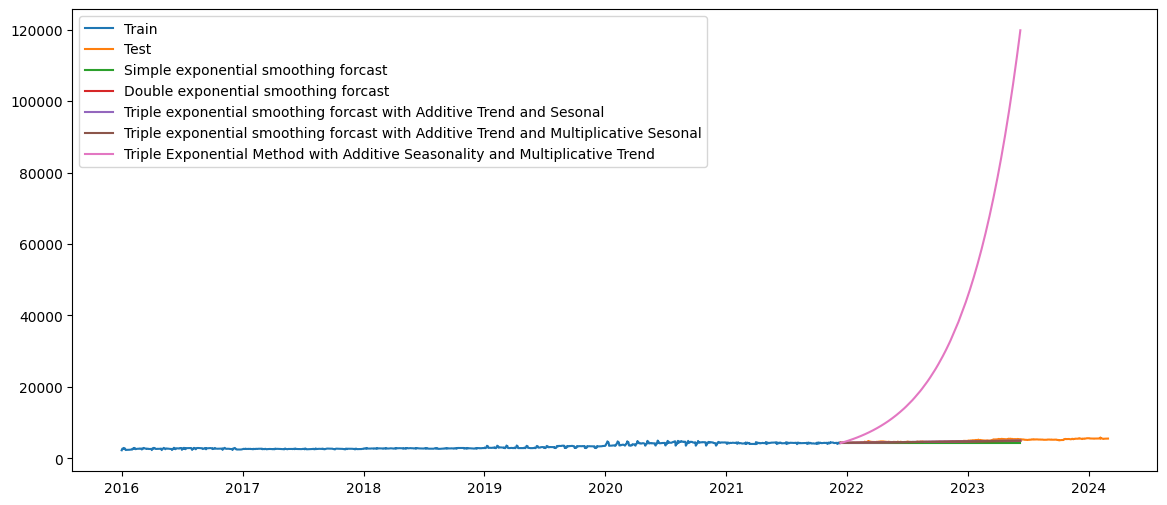

In [72]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

# Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)


In [73]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(len(test_data))
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.price))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.price)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error   = 6.506567840434739 
 Train Root Mean Squared Error = 117.96031156851036 
 Test Root Mean Squared Error  = 182.3287553121952


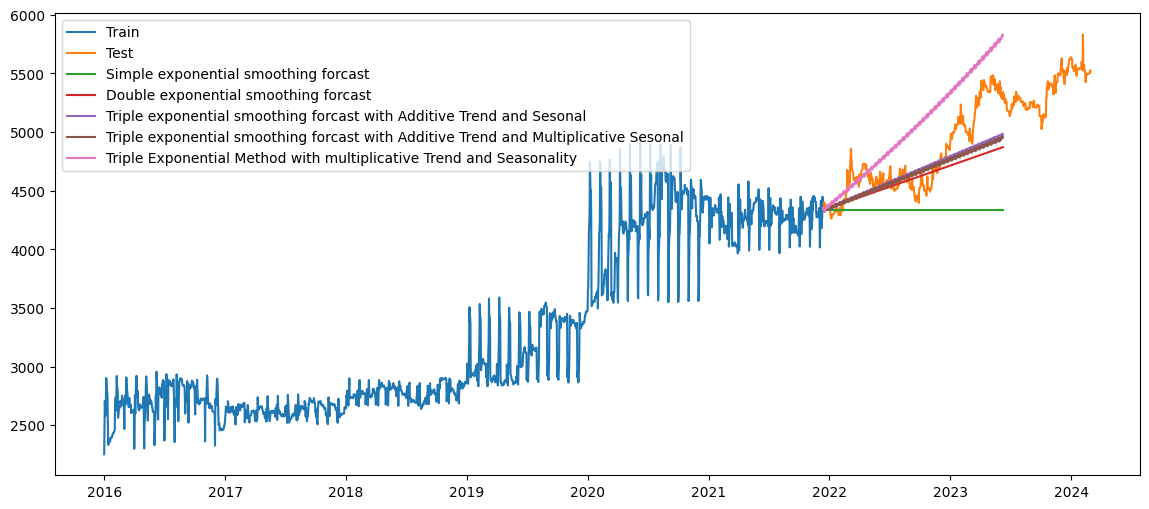

In [74]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
# plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

# Comparing the results


In [75]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul"]),
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation = pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_Add,117.601923,3.242898,382.703351
1,Triple_Exp_Mul_Add,117.991187,3.367775,398.131611
2,Double_Exp,117.012793,3.759788,438.975078
3,Triple_Exp_Mul,117.960312,6.506568,182.328755
4,Simple_Exp,114.120789,8.451404,737.429782
5,Triple_Exp_Add_Mul,240.290505,604.849092,42762.259845


# Visualizing Models Performance

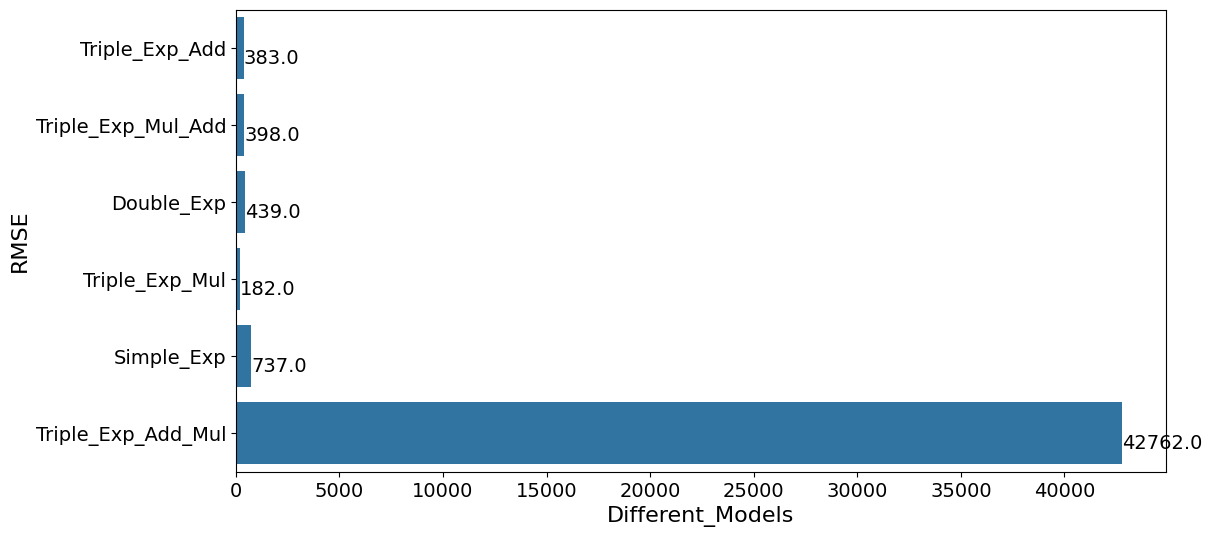

In [76]:
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x= 'Test_RMSE_Values', y= 'Models', data= table_evaluation, ax= axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize= 14)
plt.xticks(fontsize= 14)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontsize= 14)
plt.show()

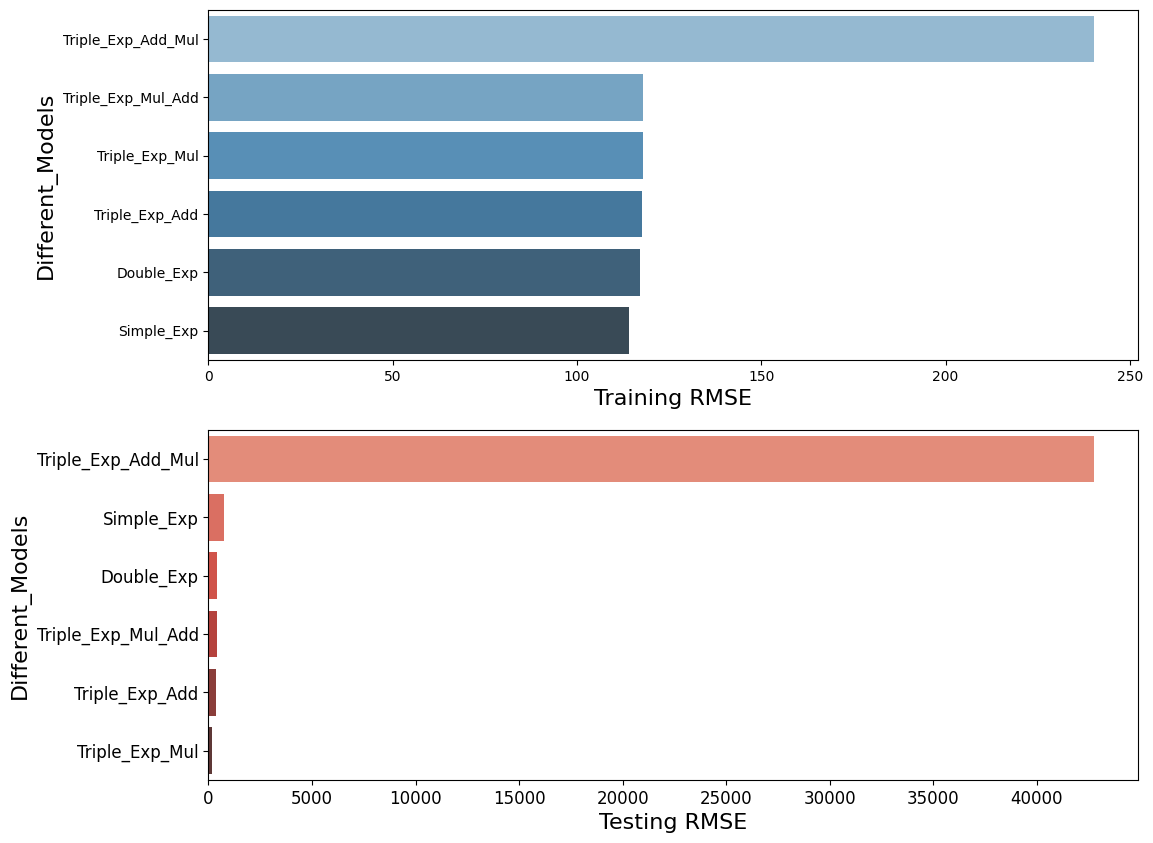

In [77]:
f, axes = plt.subplots(2,1, figsize=(12,10))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models', size=16)

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models', size=16)

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)


### Stationary vs Non-stationary Time Series
### Test of Stationarity

In [78]:
# As we have yearly data the window size for moving average is equal to 12
def test_stationarity(timeseries):

    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['price'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

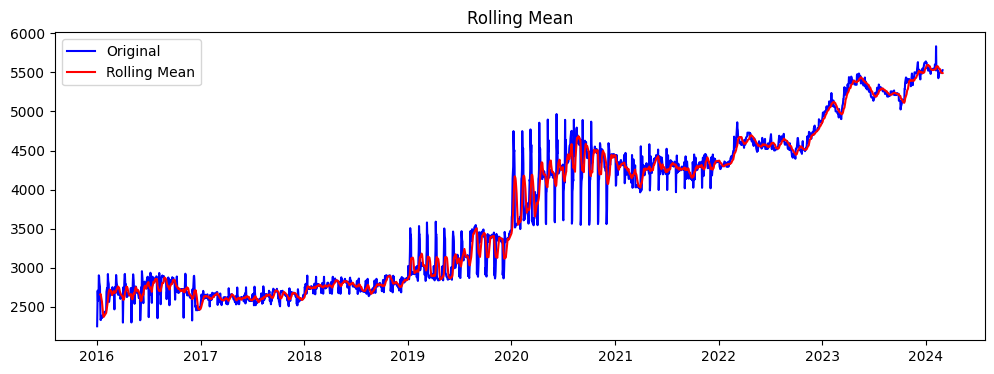

Results of Dickey Fuller Test:
Test Statistic                    1.416752
p-value                           0.997189
#Lags Used                       28.000000
Number of Observations Used    2688.000000
Critical Value (1%)              -3.432785
Critical Value (5%)              -2.862616
Critical Value (10%)             -2.567343
dtype: float64


In [79]:
plt.figure(figsize=(12,4))

test_stationarity(df[['price']])

In [80]:
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [81]:
adf_test(df[['price']])

Fail to reject the null hypothesis
Data is non-stationary


In [82]:
adf_test(df_diff[['price']])

Reject the null hypothesis
Data is stationary


# Building The Time Series Forecasting with Optimal Value using ARIMA

In [83]:
index=int(len(df_diff)*0.8)
train_data_diff=df_diff[:index]
test_data_diff=df_diff[index:]

In [84]:
len(train_data_diff),len(test_data_diff)

(2172, 544)

# ARIMA Hyperparameter Tuning

In [85]:
!pip install pmdarima

In [86]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error
# from pmdarima import auto_arima
# from math import sqrt

# def tune_arima(train, test):
#     # Fit auto_arima function to the dataset
#     model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
#     model.fit(train)

#     # Make predictions on the test set
#     predictions = model.predict(n_periods=len(test))

#     # Calculate RMSE
#     rmse = sqrt(mean_squared_error(test, predictions))
#     print('RMSE: ', rmse)
#     print(model.order)
# # Call the function
# tune_arima(train_data_diff, test_data_diff)


In [87]:
order=auto_arima(df_diff['price'])

In [88]:
order

ARIMA(order=(5, 0, 5), scoring_args={}, suppress_warnings=True)

In [89]:
arima=ARIMA(train_data,order=(5,0,5))
model_fit=arima.fit()
y_hat_ar=df_diff.copy()
y_hat_ar['arima_forecast']=model_fit.predict(df_diff.index.min(),df_diff.index.max())

# y_hat_ar['arima_forecast']=y_hat_ar['arima_forecast'].cumsum()

# y_hat_ar['arima_forecast']=y_hat_ar['arima_forecast'].add(df.price[-1])


In [90]:
ar=ARIMA(train_data_diff.price,order=(5,0,5))
model=ar.fit()
pred=df_diff.copy()
pred['arima_forecast']=model.predict(df_diff.index.min(),df_diff.index.max())

In [91]:
# Assuming 'predicted_diff' contains the predicted differences from your stationary ARIMA model
# 'initial_value' is the first value of your original time series
# 'd' is the differencing order used in the ARIMA model
def invert_diff(predicted_diff, initial_value, d):
    undiff_values = []
    prev_value = initial_value
    for diff_value in predicted_diff:
        undiff_value = prev_value + diff_value
        undiff_values.append(undiff_value)
        prev_value = undiff_value
    return undiff_values

# Convert the differenced predictions to the original scale
predicted_original = invert_diff(pred.arima_forecast,2252.600000 , 1)


In [92]:
pred['predicted']=predicted_original
pred['original']=df.iloc[1:,0]
pred

,price,arima_forecast,predicted,original
date,,,,
2016-01-02,201.900000,0.697930,2253.297930,2454.500000
2016-01-03,253.600000,-5.745985,2247.551945,2708.100000
2016-01-04,-130.300000,-44.123364,2203.428581,2577.800000
2016-01-05,19.950000,-54.827005,2148.601576,2597.750000
2016-01-06,19.950000,-17.498078,2131.103498,2617.700000
...,...,...,...,...
2024-02-23,0.000000,0.697930,1994.146605,5498.000000
2024-02-26,0.000000,0.697930,1994.844535,5498.000000
2024-02-27,16.950195,0.697931,1995.542466,5514.950195


In [93]:
rmse_arima = np.sqrt(mean_squared_error(test_data, pred['predicted'][test_data_diff.index.min():])).round(2)
rmse_arima

3159.2

In [94]:
y_hat_ar

,price,arima_forecast
date,,
2016-01-02,201.900000,2256.124969
2016-01-03,253.600000,2454.467535
2016-01-04,-130.300000,2670.600210
2016-01-05,19.950000,2523.810444
2016-01-06,19.950000,2590.886910
...,...,...
2024-02-23,0.000000,4247.403320
2024-02-26,0.000000,4247.207410
2024-02-27,16.950195,4247.132518


In [95]:
# y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

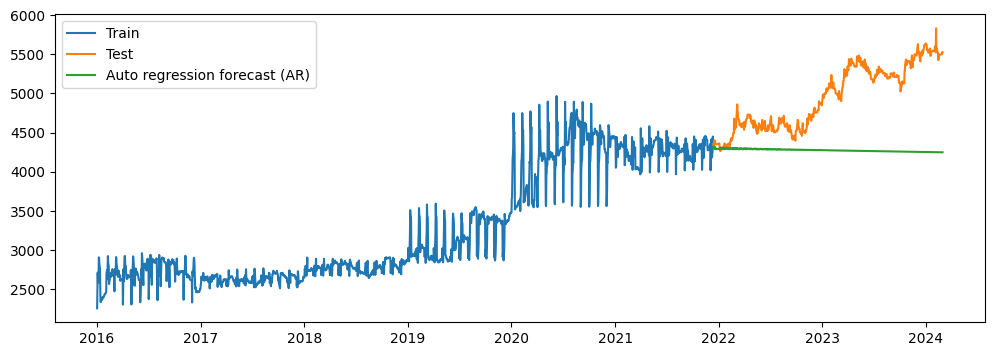

In [96]:
plt.figure(figsize=(12,4))
plt.plot(train_data['price'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data_diff.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [97]:
rmse_arima = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data_diff.index.min():])).round(2)
rmse_arima

797.82

In [98]:
# MAPE (Mean Absolute Percent Error)
mape_arima = round(np.mean(np.abs((test_data.price - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.price)*100),2)
mape_arima

13.14

In [99]:
# The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

5.3700957920862855

In [100]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


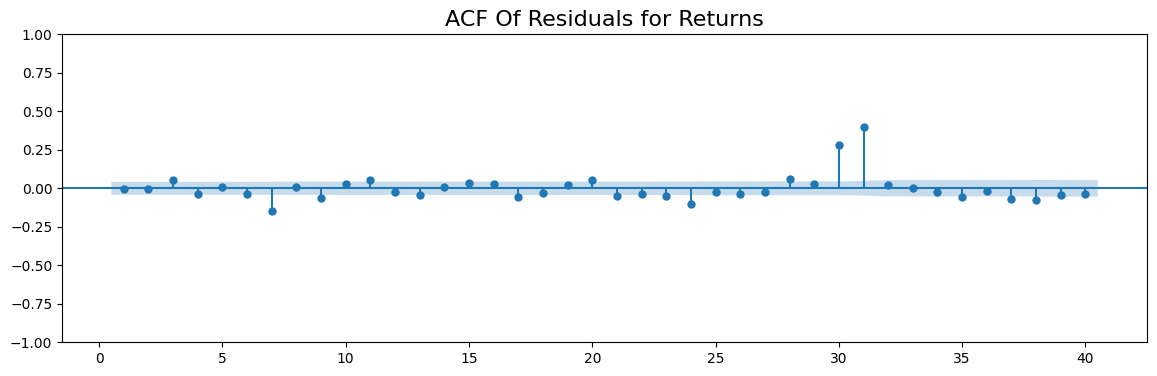

In [101]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

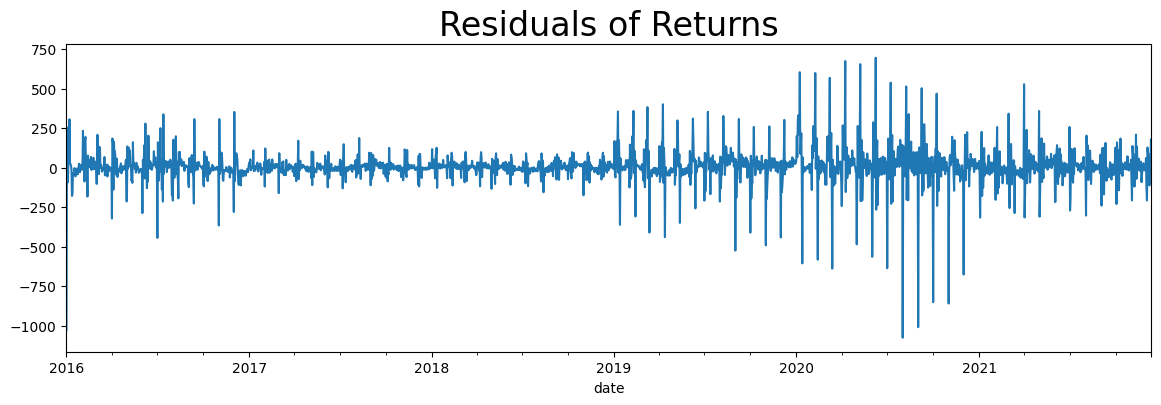

In [102]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

# Seasonal Auto Regressive Integrated Moving Average (SARIMA)


In [103]:
# import numpy as np
# import pandas as pd
# from itertools import product
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.model_selection import GridSearchCV

# def sarima_grid_search(data, p_range, d_range, q_range, P_range, D_range, Q_range, s):
#     """
#     Perform grid search for SARIMA hyperparameters.

#     Parameters:
#     - data: Time series data.
#     - p_range: Range of p values for AR parameter.
#     - d_range: Range of d values for differencing.
#     - q_range: Range of q values for MA parameter.
#     - P_range: Range of seasonal P values.
#     - D_range: Range of seasonal d values.
#     - Q_range: Range of seasonal Q values.
#     - s: Seasonal period.

#     Returns:
#     - Best SARIMA model and its parameters.
#     """
#     # Generate all possible combinations of parameters
#     param_grid = product(p_range, d_range, q_range, P_range, D_range, Q_range)

#     best_score = float("inf")
#     best_params = None
#     best_model = None

#     for param in param_grid:
#         # Unpack the parameters
#         p, d, q, P, D, Q = param

#         # Initialize SARIMA model with current parameters
#         model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s))

#         try:
#             # Fit the model
#             result = model.fit(disp=False)

#             # Calculate AIC (Akaike Information Criterion) as the score
#             score = result.aic

#             # Update best model if current model has lower AIC
#             if score < best_score:
#                 best_score = score
#                 best_params = param
#                 best_model = model
#         except:
#             continue

#     print("Best SARIMA model parameters:", best_params)
#     print("Best SARIMA model AIC:", best_score)

#     return best_model, best_params


In [104]:
# # Define your time series data


# # Define ranges for hyperparameters
# p_range = [0, 1, 2]
# d_range = [0, 1]
# q_range = [0, 1, 2]
# P_range = [0, 1, 2]
# D_range = [0, 1]
# Q_range = [0, 1, 2]
# s = 12  # Seasonal period

# # Perform grid search
# best_model, best_params = sarima_grid_search(train_data, p_range, d_range, q_range, P_range, D_range, Q_range, s)


In [105]:
# seasonal_order P=1, Q=1, D=1 and m=12 || m=12 . Because the seasonality is monthly.
model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = df_diff.copy()

In [106]:
y_hat_sarima['sarima_forecast'] = model_fit.predict(df_diff.index.min(), df_diff.index.max())
y_hat_sarima['sarima_forecast'] =(y_hat_sarima['sarima_forecast'])


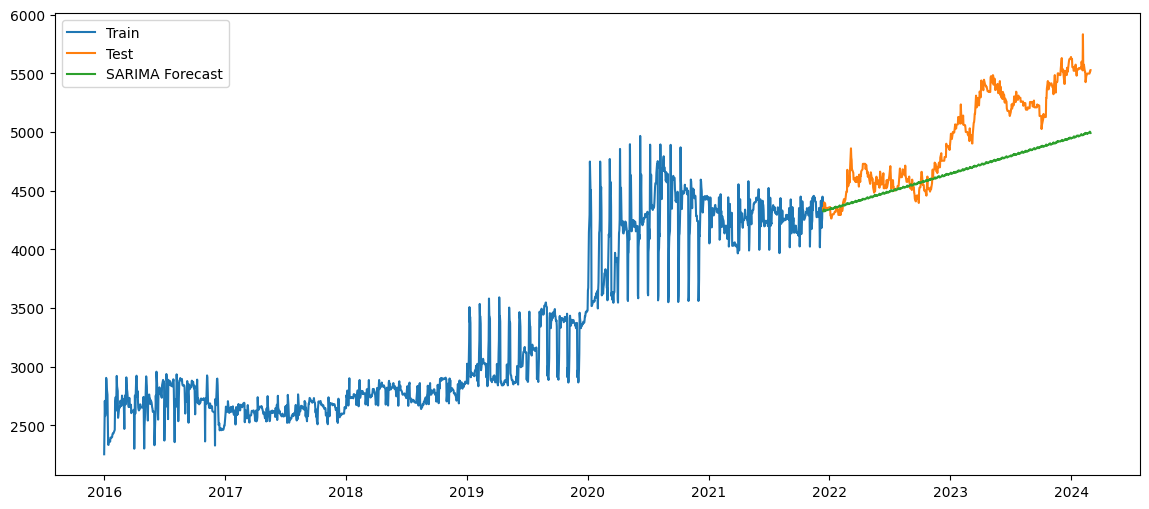

In [107]:
plt.figure(figsize=(14,6))
plt.plot(train_data['price'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [108]:
y_hat_sarima

,price,sarima_forecast
date,,
2016-01-02,201.900000,2249.622407
2016-01-03,253.600000,2451.710622
2016-01-04,-130.300000,2705.353125
2016-01-05,19.950000,2576.134170
2016-01-06,19.950000,2596.569168
...,...,...
2024-02-23,0.000000,4991.714437
2024-02-26,0.000000,4999.417885
2024-02-27,16.950195,5002.751855


In [109]:
# RMSE (Root Mean Squared Error)
rmse_sarima = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_sarima

372.72

In [110]:
# MAPE (Mean Absolute Percent Error)
mape_sarima = round(np.mean(np.abs((test_data.price - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.price)*100),2)
mape_sarima

5.86

In [111]:
# The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

1.5085952050691585

In [112]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


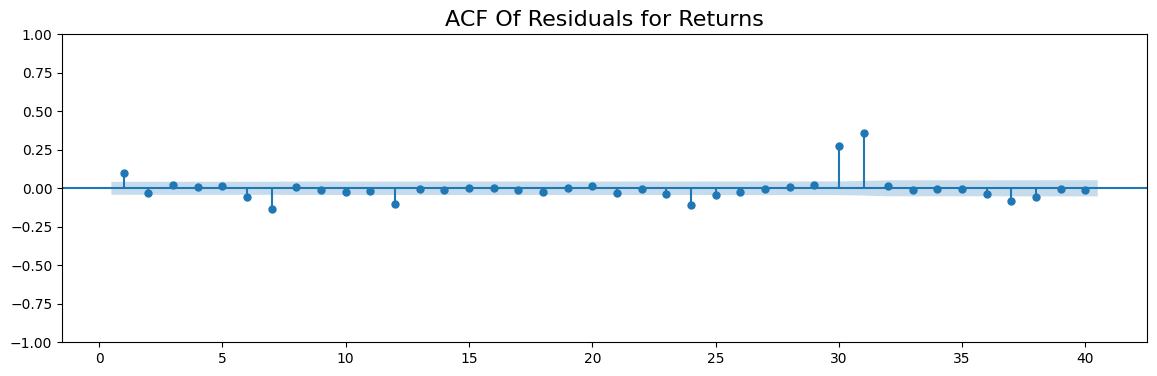

In [113]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size= 16)
plt.show()

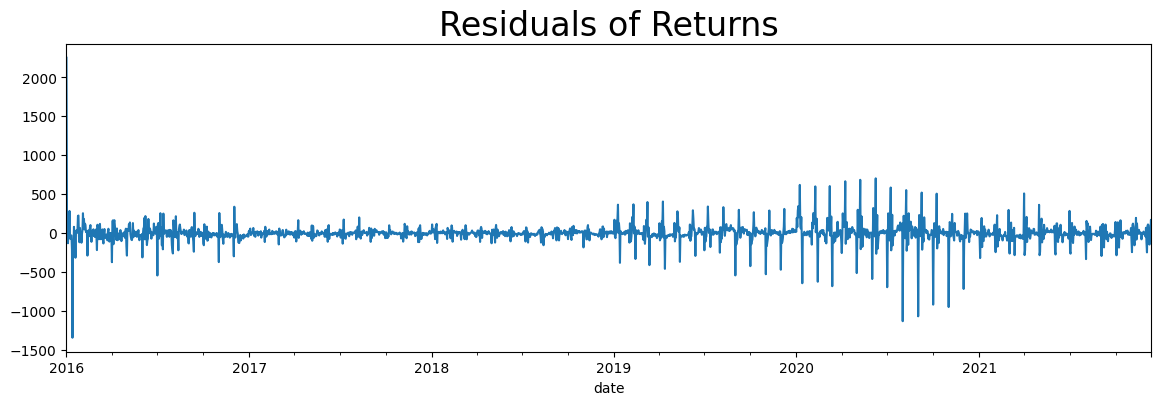

In [114]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

In [115]:
model = SARIMAX(train_data_diff, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
sarima_diff= df_diff.copy()

In [116]:
sarima_diff['sarima_forecast'] = model_fit.predict(df_diff.index.min(), df_diff.index.max())
sarima_diff['sarima_forecast'] =(sarima_diff['sarima_forecast'])


In [117]:
sarima_diff

,price,sarima_forecast
date,,
2016-01-02,201.900000,0.000000
2016-01-03,253.600000,199.254986
2016-01-04,-130.300000,252.228855
2016-01-05,19.950000,-120.518013
2016-01-06,19.950000,16.298407
...,...,...
2024-02-23,0.000000,2.302251
2024-02-26,0.000000,6.939218
2024-02-27,16.950195,3.393371


In [118]:
predicted_sar = invert_diff(sarima_diff.sarima_forecast,2252.600000 , 1)

In [119]:
sarima_diff['predicted_sar']=predicted_sar
sarima_diff

,price,sarima_forecast,predicted_sar
date,,,
2016-01-02,201.900000,0.000000,2252.600000
2016-01-03,253.600000,199.254986,2451.854986
2016-01-04,-130.300000,252.228855,2704.083841
2016-01-05,19.950000,-120.518013,2583.565828
2016-01-06,19.950000,16.298407,2599.864235
...,...,...,...
2024-02-23,0.000000,2.302251,1530.256617
2024-02-26,0.000000,6.939218,1537.195835
2024-02-27,16.950195,3.393371,1540.589206


In [120]:
rmse_arima_sar = np.sqrt(mean_squared_error(test_data, sarima_diff['predicted_sar'][test_data_diff.index.min():])).round(2)
rmse_arima_sar

3690.75

In [121]:
# Compareing the results
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_Additive","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Multiplicative","ARIMA","SARIMA"]),
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_arima,rmse_sarima])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,MAPE(%),RMSE_Values
0,Triple_Exp_Multiplicative,6.506568,182.328755
1,SARIMA,5.860000,372.720000
2,Triple_Exp_Additive,3.242898,382.703351
3,Triple_Exp_Mul_Add,3.367775,398.131611
4,Double_Exponential,3.759788,438.975078
5,Simple_Exponential,8.451404,737.429782
6,ARIMA,13.140000,797.820000
7,Triple_Exp_Add_Mul,604.849092,42762.259845


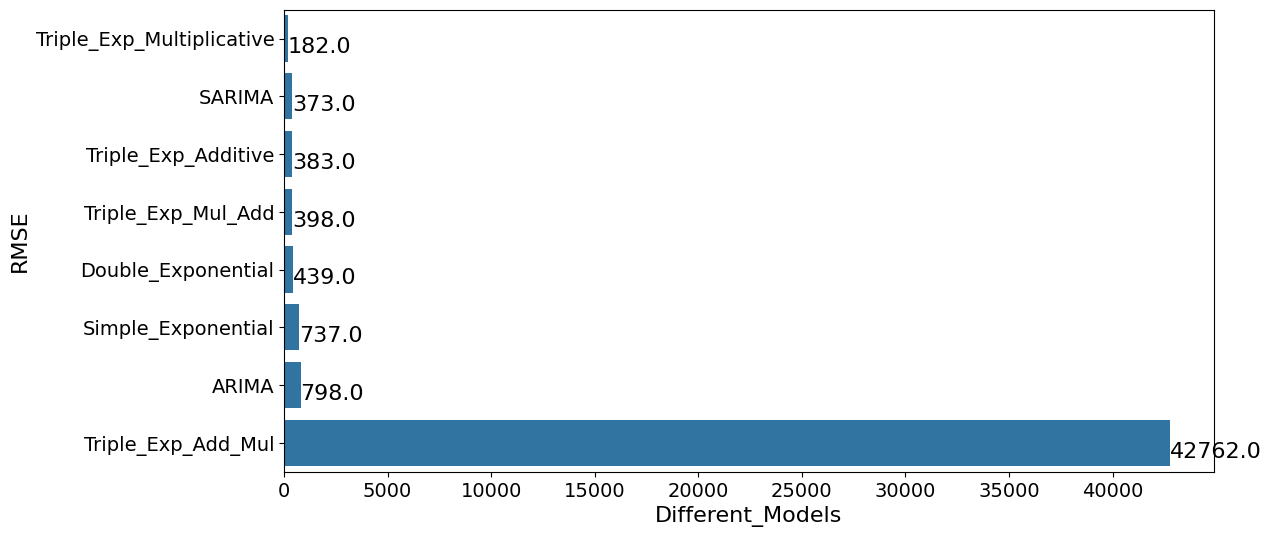

In [122]:
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 16)

plt.show()

# Data Pre-processing for Model Driven Techniques


In [123]:
gold


,date,price
0,2016-01-01,2252.600000
1,2016-01-02,2454.500000
2,2016-01-03,2708.100000
3,2016-01-04,2577.800000
4,2016-01-05,2597.750000
...,...,...
2712,2024-02-23,5498.000000
2713,2024-02-26,5498.000000
2714,2024-02-27,5514.950195
2715,2024-02-28,5514.899902


In [124]:
gold['t']=np.arange(1,len(gold)+1)
gold['t_squared']=np.square(gold.t)
gold['month']=gold.date.dt.strftime("%b")
gold["year"] = gold.date.dt.strftime("%Y")
months = pd.get_dummies(gold['month']).astype('int')
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
gold = pd.concat([gold,months],axis=1)
gold['log_price']=np.log(gold['price'])
gold

,date,price,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_price
0,2016-01-01,2252.600000,1,1,Jan,2016,1,0,0,0,0,0,0,0,0,0,0,0,7.719840
1,2016-01-02,2454.500000,2,4,Jan,2016,1,0,0,0,0,0,0,0,0,0,0,0,7.805678
2,2016-01-03,2708.100000,3,9,Jan,2016,1,0,0,0,0,0,0,0,0,0,0,0,7.904003
3,2016-01-04,2577.800000,4,16,Jan,2016,1,0,0,0,0,0,0,0,0,0,0,0,7.854692
4,2016-01-05,2597.750000,5,25,Jan,2016,1,0,0,0,0,0,0,0,0,0,0,0,7.862401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,2024-02-23,5498.000000,2713,7360369,Feb,2024,0,1,0,0,0,0,0,0,0,0,0,0,8.612140
2713,2024-02-26,5498.000000,2714,7365796,Feb,2024,0,1,0,0,0,0,0,0,0,0,0,0,8.612140
2714,2024-02-27,5514.950195,2715,7371225,Feb,2024,0,1,0,0,0,0,0,0,0,0,0,0,8.615218
2715,2024-02-28,5514.899902,2716,7376656,Feb,2024,0,1,0,0,0,0,0,0,0,0,0,0,8.615209


In [125]:
size=int(len(gold)*0.8)
train_data=gold[:size]
test_data=gold[size:]

In [126]:
len(train_data),len(test_data)

(2173, 544)

# Building Ordinary Square Model

In [127]:
# Linear Model
linear_model = smf.ols('price~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['price'])-np.array(pred_linear))**2))
rmse_linear

401.36106336164386

In [128]:
# Exponential Model
exp = smf.ols('log_price~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['price'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

255.51881094466137

In [129]:
# Quadratic model
quad = smf.ols('price~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['price'])-np.array(pred_quad))**2))
rmse_quad

522.0705406450865

In [130]:
# Additive seasonality
add_sea = smf.ols('price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['price'])-np.array(pred_add_sea))**2))
rmse_add_sea

1732.8960623346866

In [131]:
# Additive Seasonality Quadratic
add_sea_quad = smf.ols('price~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['price'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

527.012115374132

In [132]:
# Multiplicative Seasonality
mul_sea = smf.ols('log_price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['price'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

1779.9802625760115

In [133]:
# Multiplicative Additive Seasonality
mul_add_sea = smf.ols('log_price~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(test_data))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(test_data['price'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea

252.4628140376467

In [134]:
np.exp(pred_mult_add_sea)

2173    4252.895937
2174    4254.173698
2175    4255.451842
2176    4256.730371
2177    4258.009283
           ...     
2712    5348.585598
2713    5350.192553
2714    5351.799991
2715    5353.407911
2716    5355.016315
Length: 544, dtype: float64

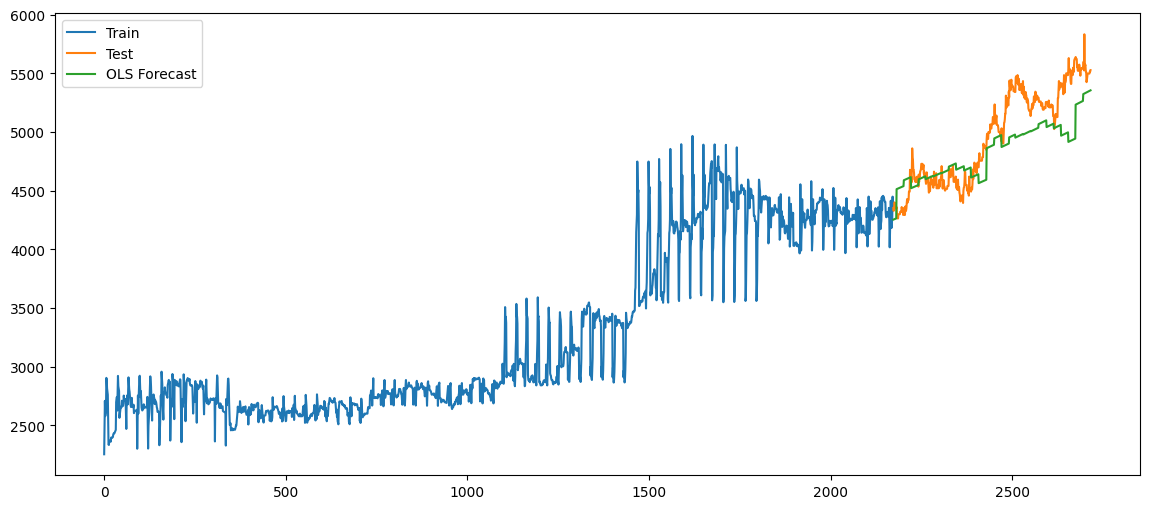

In [135]:
plt.figure(figsize=(14,6))
plt.plot(train_data['price'], label='Train')
plt.plot(test_data['price'], label='Test')
plt.plot(np.exp(pred_mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

# Compare the results


In [136]:
data = {"Models":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad","RMSE_Add_Sea","RMSE_Add_Sea_Quad","RMSE_Mult_Sea","RMSE_Mult_Add_Sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [137]:
table_rmse,table_evaluation

(              Models  RMSE_Values
 0  RMSE_Mult_Add_Sea   252.462814
 1           RMSE_Exp   255.518811
 2        RMSE_Linear   401.361063
 3          RMSE_Quad   522.070541
 4  RMSE_Add_Sea_Quad   527.012115
 5       RMSE_Add_Sea  1732.896062
 6      RMSE_Mult_Sea  1779.980263,
                       Models     MAPE(%)   RMSE_Values
 0  Triple_Exp_Multiplicative    6.506568    182.328755
 1                     SARIMA    5.860000    372.720000
 2        Triple_Exp_Additive    3.242898    382.703351
 3         Triple_Exp_Mul_Add    3.367775    398.131611
 4         Double_Exponential    3.759788    438.975078
 5         Simple_Exponential    8.451404    737.429782
 6                      ARIMA   13.140000    797.820000
 7         Triple_Exp_Add_Mul  604.849092  42762.259845)

In [138]:
e = table_rmse.merge(table_evaluation,how='outer')
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [139]:
e

,Models,RMSE_Values
0,Triple_Exp_Multiplicative,182.328755
1,RMSE_Mult_Add_Sea,252.462814
2,RMSE_Exp,255.518811
3,SARIMA,372.720000
4,Triple_Exp_Additive,382.703351
5,Triple_Exp_Mul_Add,398.131611
6,RMSE_Linear,401.361063
7,Double_Exponential,438.975078
8,RMSE_Quad,522.070541
9,RMSE_Add_Sea_Quad,527.012115


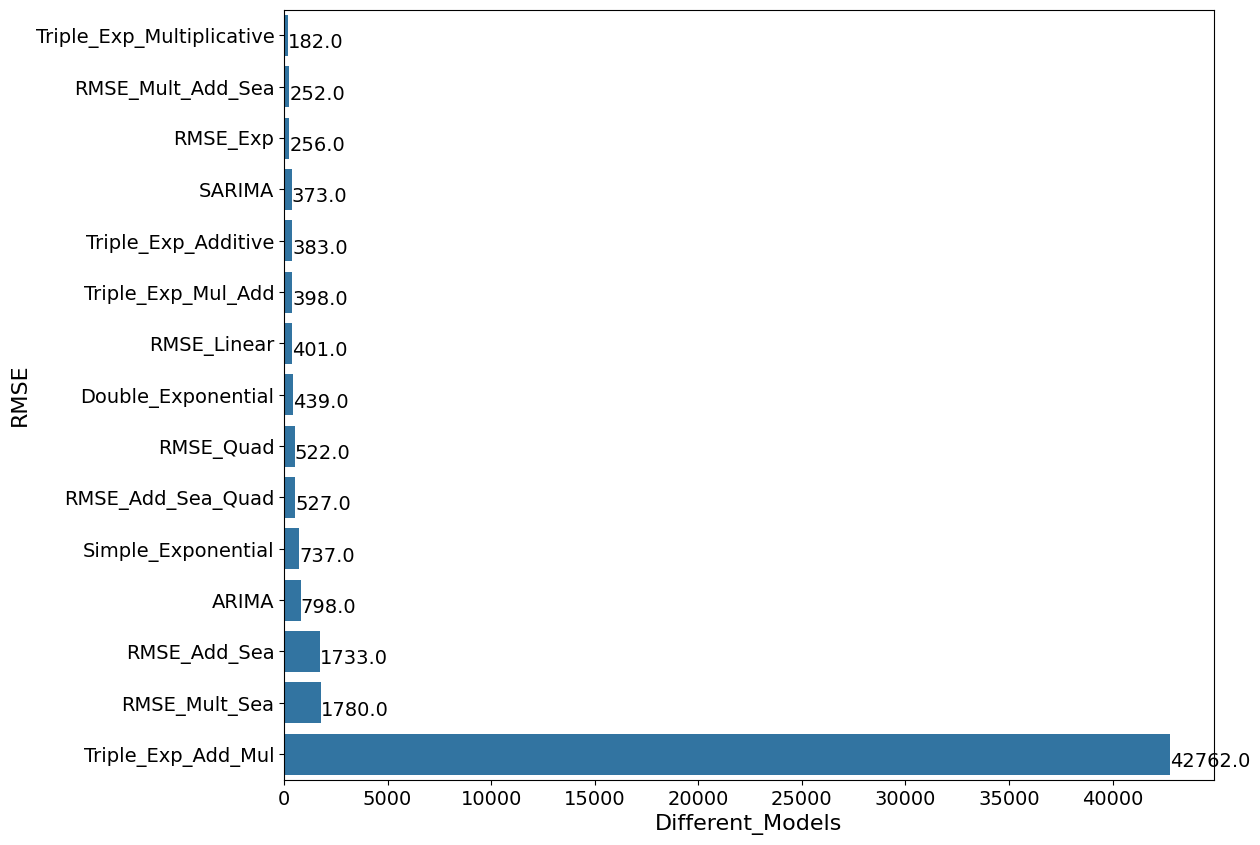

In [140]:
f, axe = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)

plt.show()

# **BUILDING RNN MODEL**

In [142]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
# Assuming your dataset has a column named 'price' containing the daily gold prices
# Replace 'your_dataset.csv' with the path to your dataset
dataset = df.copy()
gold_prices = dataset['price'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_gold_prices = scaler.fit_transform(gold_prices)

# Define the window size for input sequences
window_size = 30

# Create sequences of input data and corresponding labels
X = []
y = []
for i in range(len(scaled_gold_prices) - window_size):
    X.append(scaled_gold_prices[i:i+window_size, 0])
    y.append(scaled_gold_prices[i+window_size, 0])
X = np.array(X)
y = np.array(y)

# Reshape the input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the RNN model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)





Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0195
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 12/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 13/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 14/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 15/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoc

In [143]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [144]:
def predict_future_days(model, scaler, last_window, num_days):
    """
    Predict future gold prices for the specified number of days.

    Args:
    - model: Trained LSTM model
    - scaler: MinMaxScaler used for normalization
    - last_window: Last window of data from the dataset
    - num_days: Number of future days to predict

    Returns:
    - DataFrame with predicted prices for future days
    """
    future_predictions = []
    for _ in range(num_days):
        prediction = model.predict(last_window)
        future_predictions.append(prediction[0, 0])

        # Update the input sequence for the next prediction
        last_window = np.roll(last_window, -1, axis=1)
        last_window[0, -1, 0] = prediction[0, 0]

    # Inverse transform the future predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Generate future dates for the predictions
    last_date = dataset.index[-1]
    future_dates = pd.date_range(start=last_date, periods=num_days + 1)[1:]  # Start from the day after the last date

    # Create a DataFrame for the future predictions
    future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': future_predictions.flatten()})

    # Set the 'Date' column as the index
    future_df.set_index('Date', inplace=True)

    return future_df

# Usage example:
num_future_days = 40  # Change this to the desired number of future days to predict
last_window = scaled_gold_prices[-window_size:].reshape(1, window_size, 1)
future_predictions = predict_future_days(model, scaler, last_window, num_future_days)
print(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━